In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'human_vital_signs.csv'
data = pd.read_csv(file_path)
data.head(5)

# Drop unnecessary columns
data = data.drop(columns=['Patient ID', 'Timestamp'])

# Encode categorical variables
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Risk Category'] = label_encoder.fit_transform(data['Risk Category'])

# Features and target variable
features = data.drop(columns=['Risk Category'])
target = data['Risk Category']

# Convert features to float to avoid type compatibility issues
features = features.astype(float)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Convert y_train to a 1D array
y_train = y_train.ravel()

# Expand dimensions for compatibility with RNN input
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)


C:\Users\tharu\AppData\Local\Temp\ipykernel_11256\2604958681.py:34: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()


In [11]:
data.head(5)


,Heart Rate,Respiratory Rate,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Gender,Weight (kg),Height (m),Derived_HRV,Derived_Pulse_Pressure,Derived_BMI,Derived_MAP,Risk Category
0,60,12,36.861707,95.702046,124,86,37,0,91.541618,1.679351,0.121033,38,32.459031,98.666667,0
1,63,18,36.511633,96.689413,126,84,77,1,50.704921,1.992546,0.117062,42,12.771246,98.000000,0
2,63,15,37.052049,98.508265,131,78,68,0,90.316760,1.770228,0.053200,53,28.821069,95.666667,1
3,99,16,36.654748,95.011801,118,72,41,0,96.006188,1.833629,0.064475,46,28.554611,87.333333,0
4,69,16,36.975098,98.623792,138,76,25,0,56.020006,1.866419,0.118484,62,16.081438,96.666667,0


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, SimpleRNN, GlobalAveragePooling1D

# RNN model
def build_rnn_model(input_shape, rnn_units, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(rnn_units, return_sequences=True, dropout=dropout)(inputs)
    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs, outputs)

# Build the model
input_shape = (X_train.shape[1], 1)
model = build_rnn_model(
    input_shape=input_shape,
    rnn_units=128,
    mlp_units=[128],
    dropout=0.1,
    mlp_dropout=0.1
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 14, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 14, 128)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 14)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,689 (73.00 KB)

 Trainable params: 18,689 (73.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.6931 - loss: 0.5380 - val_accuracy: 0.9480 - val_loss: 0.1534
Epoch 2/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9053 - loss: 0.1907 - val_accuracy: 0.9359 - val_loss: 0.1643
Epoch 3/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9212 - loss: 0.1405 - val_accuracy: 0.9672 - val_loss: 0.1077
Epoch 4/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9320 - loss: 0.1179 - val_accuracy: 0.9396 - val_loss: 0.1893
Epoch 5/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9327 - loss: 0.1180 - val_accuracy: 0.9390 - val_loss: 0.2270


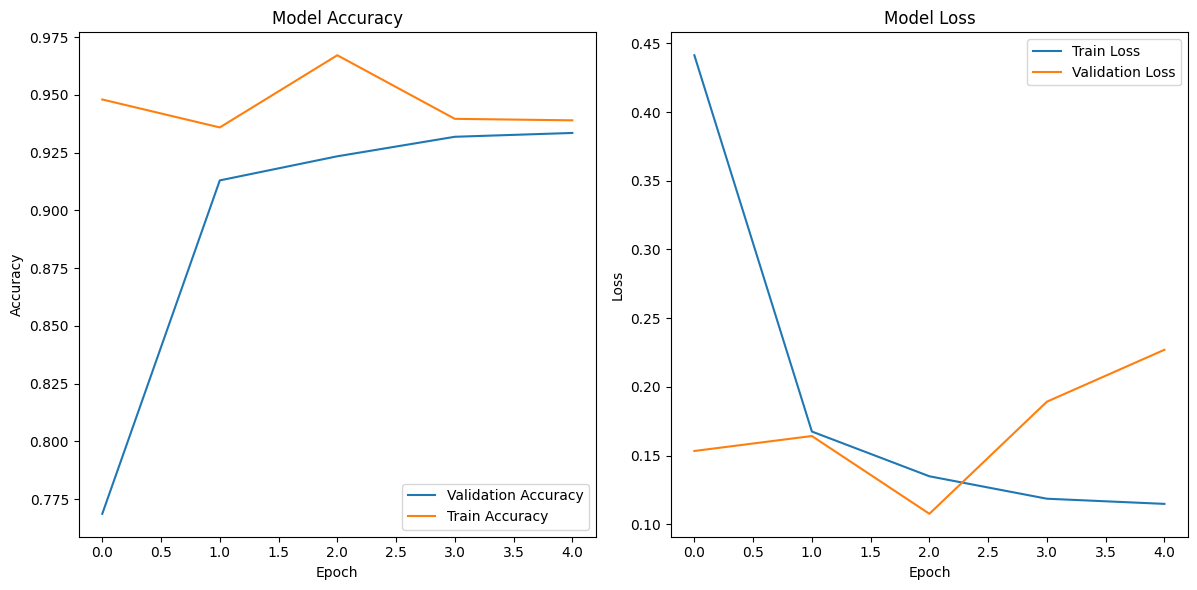

In [19]:
plt.figure(figsize=(18, 6))

# Plot training & validation accuracy values
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')


# Apply some additional style
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Precision: 0.89
Recall: 1.00
F1 Score: 0.94


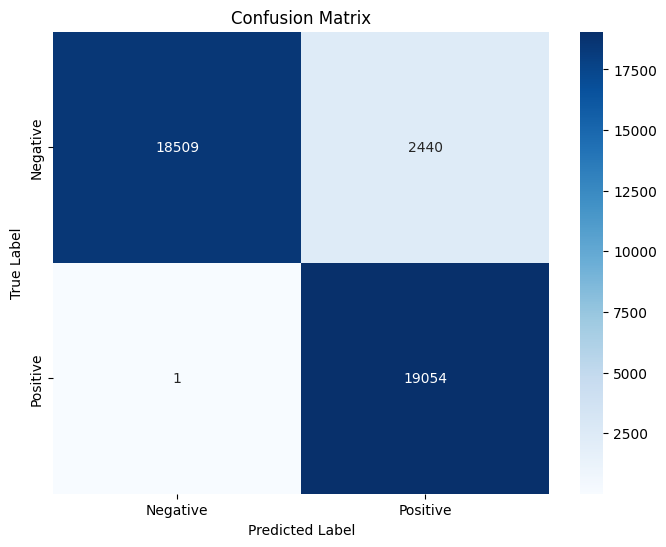

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


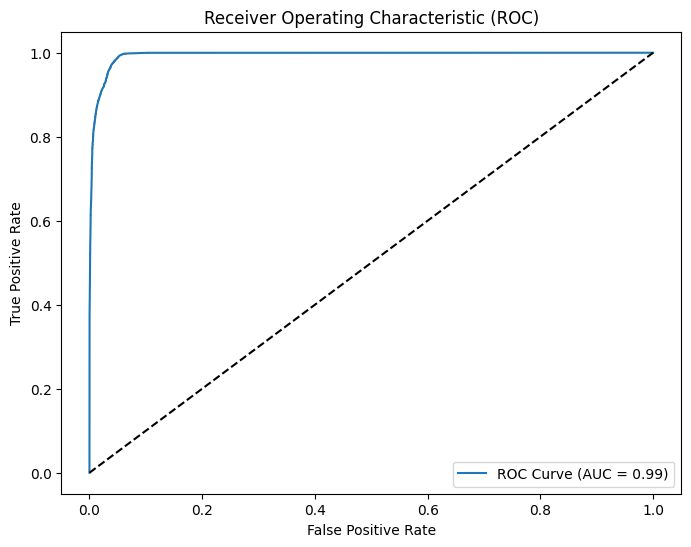

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))

# Calculate AUC
auc = roc_auc_score(y_test, model.predict(X_test))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [18]:
# Preprocessing function
def preprocess_input(input_data):
    input_df = pd.DataFrame([input_data], columns=features.columns)  # Convert input data to DataFrame with feature names
    input_data_scaled = scaler.transform(input_df)
    input_data_scaled = np.expand_dims(input_data_scaled, -1)  # Expand dims to match model input
    return input_data_scaled

# Prediction function
def predict_risk_category(input_data):
    input_data_scaled = preprocess_input(input_data)
    prediction = model.predict(input_data_scaled)
    risk_category = (prediction > 0.5).astype(int)
    return label_encoder.inverse_transform(risk_category)[0]

# Sample input data for testing
low_risk_input = [63, 15, 37.05, 98.5, 131, 78, 68, 0, 90.32, 1.77, 0.0532, 53, 28.82, 95.67]  # Ensure this matches the feature count
low_risk_category = predict_risk_category(low_risk_input)
print(f'The predicted risk category for low risk input is: {low_risk_category}')

high_risk_input = [96, 15, 36.85, 97.12, 135, 77, 72, 0, 71.76, 1.60, 0.0734, 58, 27.90, 96.33]  # Ensure this matches the feature count
high_risk_category = predict_risk_category(high_risk_input)
print(f'The predicted risk category for high risk input is: {high_risk_category}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The predicted risk category for low risk input is: Low Risk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The predicted risk category for high risk input is: High Risk


C:\Users\tharu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tharu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
